In [1]:
%reload_ext autoreload
%autoreload 2


In [4]:
from formula_detection.context import count_pre_post_phrase_context
from notebooks.corpus_iterables import get_resolutions_sents

data_dir = '/Users/marijnkoolen/Code/Huygens/republic-project/data/paragraphs'
resolution_file = f'{data_dir}/resolutions-paragraphs-random.tsv.gz'

res_sents = get_resolutions_sents(resolution_file)



In [ ]:
context_size = 5
phrases = [
    'resident spina',
    'resident rumpf'
]

context_count = count_pre_post_phrase_context(phrases, res_sents, context_size=context_size)


In [3]:
# context_count object has three keys
context_count.keys()

dict_keys(['phrase', 'pre', 'post'])

In [4]:
# 'phrase' is just a count of the phrases
context_count['phrase']

Counter({'resident rumpf': 2637, 'resident spina': 3306})

In [5]:
# 'pre' contains a dictionary with phrases as keys and prefix context Counters as values
context_count['pre'].keys()

dict_keys(['resident rumpf', 'resident spina'])

In [6]:
# The 'pre' counter for a phrase contains the counts of prefix context of that phrase
context_count['pre']['resident spina']

Counter({'ontfangen een missive van den': 2755,
         'ontfangen cen missive van den': 102,
         'gelesen de requeste van den': 25,
         'ende verftaan dat aan gemelden': 1,
         'ontfangen een misssve van den': 1,
         'ontangen een missive van den': 1,
         'gelelen de requeste van den': 2,
         'resolutie gesonden werden aen den': 2,
         'ende verstaen dat aen gemelden': 14,
         'haer hoogh mogende der selver': 1,
         'goedtgevonden ende verstaen dat den': 4,
         'van de missiven van den': 1,
         'ontfangen een misfive van den': 6,
         'dontfangen een missive van den': 8,
         'geëxamineert de missive van den': 7,
         'en verstaan dat aan gemelden': 11,
         'ende verstaan dat aan gemelden': 40,
         'ontfangen een mishve van den': 6,
         'geexamineert de requeste van den': 1,
         'gesonden sal werden aen den': 7,
         '<START> ontfangenjeen missive van den': 1,
         'te verzoecken dat aan ge

In [7]:
# The 'post' counter for a phrase contains the counts of postfix context of that phrase
context_count['post']['resident spina']

Counter({'geschreven tot franckfort den 20': 6,
         'geschreven te franckfort den elfden': 62,
         'geschreven te franckfort den aghtsten': 42,
         'geschreven tot franckfort den vyf': 10,
         'geschreven te francksort den ses': 2,
         'geschreven te franckfort den sesden': 71,
         'geschreven te franckfort den dertienden': 56,
         'geschreven tot franckfort den seventienden': 19,
         'geschreven te franckfort den vyf': 56,
         'geschreven te franckfort den tweeden': 73,
         'leverende daer nevens over sijne': 2,
         'geschreven te franckfort den negen': 43,
         'geschreven tot franckfort den derden': 22,
         'geschreven te franckfort den twaalfden': 55,
         'geschreven te franckfort den een': 97,
         'geschreeven te franckfort den elfden': 6,
         'geschreeven te franckfort den seeventienden': 6,
         'geschreven te fanckfort den ses': 1,
         'geschreven te franckfort den twee': 62,
         'gesch

In [8]:
from hist_text_template.context import map_context_word_variants

# you can add mappings of word variants that
# you want to collapse to a preferred spelling
known_variants = {
    'ende': 'en',
}


variant_of = map_context_word_variants(phrases, context_count, w2v_model=None, 
                                           sim_threshold=0.75, known_variants=known_variants)



In [9]:
variant_of

{'ende': 'en'}

In [10]:
from hist_text_template.transitions import compute_transition_probs

transition_probs = compute_transition_probs(phrases, context_count,
                                            variant_of=variant_of, from_phrase=False)


In [11]:
transition_probs

defaultdict(<function hist_text_template.transitions.compute_transition_probs.<locals>.<lambda>()>,
            {'pre': defaultdict(dict,
                         {'<PHRASE>': {'den': 0.933703516742386},
                          'den': {'van': 0.9179362880886427},
                          'van': {'missive': 0.8547709923664122,
                           '<VAR-2>': 0.13110687022900763},
                          'missive': {'een': 0.9605702829137892},
                          'een': {'ontfangen': 0.9814566577301161},
                          '<VAR-3>': {'ontfangen': 0.24121013900245297,
                           '<VAR-4>': 0.6892886345053147},
                          '<VAR-2>': {'<VAR-3>': 0.7154811715481172,
                           'een': 0.11506276150627615,
                           'den': 0.13179916317991633},
                          'ontfangen': {},
                          '<VAR-4>': {}}),
             'post': defaultdict(dict,
                         {'<PHRASE>': {

In [12]:
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline


def draw_transition_probs(phrase, transition_probs, direction: str, image_dir: str):
    if direction not in {'pre', 'post'}:
        raise ValueError('direction must be "pre" or "post"')
    dot = Digraph(comment=f'Transition probabilities for phrase "{phrase}"', format='png')
    node_map = {}

    for source in sorted(transition_probs[direction].keys(), key=lambda x: len(x)):
        if source not in node_map:
            node_map[source] = str(len(node_map))
            source_label = source if isinstance(source, str) else source[-1]
            if source_label == '<PHRASE>':
                source_label = phrase
            dot.node(node_map[source], source_label)
        source_id = node_map[source]
        for target in transition_probs[direction][source]:
            if target not in node_map:
                node_map[target] = str(len(node_map))
                target_label = target if isinstance(target, str) else target[-1]
                dot.node(node_map[target], target_label)
            target_id = node_map[target]
            if direction == 'pre':
                dot.edge(target_id, source_id, label=f"{transition_probs[direction][source][target]: >.2f}")
            else:
                dot.edge(source_id, target_id, label=f"{transition_probs[direction][source][target]: >.2f}")
    dot.render(f'{image_dir}/sub_phrase-markov-{direction}-{phrase.replace(" ", "_")}.gv', view=True)
    display(dot)


image_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Papers/2022/CHR-2022-Formulas/Images/transition'



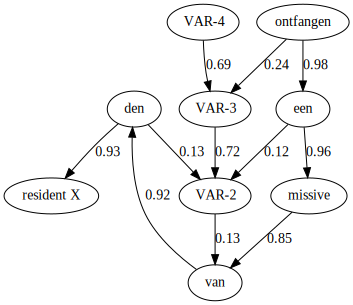

In [13]:
draw_transition_probs('resident X', transition_probs, 'pre', image_dir)

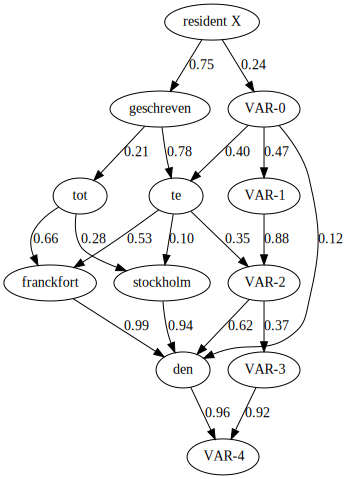

In [14]:
draw_transition_probs('resident X', transition_probs, 'post', image_dir)

In [6]:
for sent in res_sents:
    phrase = 'gestelt'
    if phrase in sent['text']:
        print(sent)
        index = sent['text'].index(phrase)
        print(sent['text'][index-40:index+40])
        break



{'doc_id': 'session-1711-04-14-num-1-resolution-20', 'id': 'session-1711-04-14-num-1-para-22', 'text': 'IS ter Vergaderinge gelesen de Requeste van Pieter Goodschalck, geboorene Burger ende Artilleryemeester der Stadt Leyden, houdende, dat hy Suppliant sigh den negenden deser hadde geaddresseert aen haer Hoogh Mogende, ende versocht, dat als by de Bewindthebberen van de geoctroyeerde Oost - Indische Compagnie was bericht ofte gerescribeert op des Suppliants gepresenteerde Requeste, aen hem mochte werden verleent Copie van het voorschreve Bericht ofte Rescriptie, om haer Hoogh Mogende omtrent den inhoude van dien nader te informeren, alvoorens eenige finale Resolutie in die saecke mochte werden genomen; dat haer Hoogh Mogende het selve Request by der selver Resolutie hadden aengenomen ende gehouden voor antidotael ; dat den Suppliant bericht was, dat de Bewindthebberen van de Oost-Indische Compagnie der selver Bericht ofte Rescriptie den tienden deser loopende maendt aen haer Hoogh Moge